This notebook examines an improved method of identifying the heating and cooling sensitivity in an aggregate load data set.  The improvement focuses on how the heating and cooling balance temperatures are identified. The  current method using a simple search to find the temperatures based on an assumption that they are about 10 degF apart.  This improvement performs a 3 segment piecewise linear fit to determine the values of $T_{heat}$ and $T_{cool}$. If the slopes of cooling or heating segments are too small, the either or both of the segments are removed and the corresponding temperature, power, and slope values are set to `np.nan`.

This cell sets the default parameters for how this notebook works.

In [1]:
class config:
    
    # Test data specifications
    DataFile = r'weather/testdata.csv'
    DatetimeCol = 0
    PowerCol = 1
    TemperatureCol = 2
    DatetimeName = "datetime"
    PowerName = "power"
    TemperatureName = "temperature"
    

Now we load the weather sensitivity analysis module and load the test data.

In [2]:
import weather.sensitivity as lm
data = lm.load_data(ifile=config.DataFile,
                    datetime_col=config.DatetimeCol,
                    power_col=config.PowerCol,
                    temperature_col=config.TemperatureCol,
                    names = {
                        config.DatetimeCol : config.DatetimeName, 
                        config.PowerCol : config.PowerName,
                        config.TemperatureCol : config.TemperatureName,
                    }
                   )

We then load the libraries and define helper functions.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import pwlf

def partition_data(data,Theat,Tcool):
    
    T = data['temperature']
    heat = np.where(T<Theat)
    base = np.where((T>=Theat) & (T<Tcool))
    cool = np.where(T>=Tcool)
    return heat[0],base[0],cool[0]
    
def find_balance_temperatures(x,y):

    model = pwlf.PiecewiseLinFit(x, y)

    pt2 = model.fit(2)
    yp2 = model.predict(x)
    er2 = pow(yp2-y,2).sum()

    pt3 = model.fit(3)
    yp3 = model.predict(x)
    er3 = pow(yp3-y,2).sum()

    Tdiff = pt3[2]-pt3[1]
    Tbase = pt2[1]

    Theat = Tbase - Tdiff/2
    Tcool = Tbase + Tdiff/2
    
    return (Theat, Tcool)

class Model:
    
    def __init__(self,x,y,n):
    
        self.model = pwlf.PiecewiseLinFit(x,y)
        self.data = (x,y)
        self.n = n
        self.x = X = self.model.fit(n)
        self.y = Y = self.model.predict(X)
        self.s = S = (Y[1:]-Y[0:-1]) / (X[1:]-X[0:-1])
        self.i = (Y[1:]+Y[0:-1] -S*(X[1:]+X[0:-1])) / 2
    
    def __str__(self):
        result = f"{repr(self)}\n    n = {self.n}\n"
        result += f"    x = {self.x}\n"
        result += f"    y = {self.y}\n"
        result += f"    s = {self.s}\n"
        result += f"    i = {self.i}\n"
        return result
    
    def to_dict(self):
        return {"x": self.x, "y": self.y, "s" : self.s, "i" : self.i}
    
    def get_data(self):
        return model.data
    
    def predict(self,x):
        return self.model.predict(x)
    

We can now process the data hour-by-hour, finding the balance temperatures, performing the piecewise linear regression based on those balance temperatures, and displaying the results for each hour.

/Volumes/DATA/Anaconda/anaconda3/lib/python3.7/site-packages/pwlf/pwlf.py:1109: RuntimeWarning: invalid value encountered in double_scalars
  (self.fit_breaks[i+1]-self.fit_breaks[i])


,Pbase,Pheat,Pcool,Tmin,Theat,Tcool,Tmax,Sbase,Sheat,Scool
0,1776.166961,2696.840569,2712.596397,22.01,52.909730,62.124560,83.07,7.844234,-30.965165,42.982520
1,1691.955441,2643.954313,2495.977212,21.65,52.156282,60.770000,81.88,5.679717,-32.008510,36.928471
2,1644.712704,2629.066864,2323.860213,21.50,51.150000,59.054591,80.69,0.728387,-33.296221,31.257495
3,1642.220234,2667.915354,2192.648416,21.34,49.421902,57.347400,78.81,-8.127423,-35.378237,27.146530
4,1684.335150,2775.172760,2148.956539,20.89,49.230314,56.589538,77.53,-11.190671,-37.037709,24.154134
5,1789.951052,2974.705304,2192.744380,20.49,52.109998,57.832400,75.74,-0.292084,-37.442082,22.539539
6,1989.073559,3274.685988,2296.551041,20.43,53.259660,58.680000,75.74,-4.284066,-38.806429,18.703870
7,2156.401391,3492.508111,2524.927684,20.16,53.839999,58.799956,81.21,-12.338641,-38.762090,17.810133
8,2241.769917,3560.179255,2717.425274,20.25,54.570001,59.878717,83.77,-8.675513,-37.744213,20.873022
9,2305.446667,3568.456767,2919.829578,21.56,54.970000,61.931678,86.63,-5.215037,-37.260024,25.610469


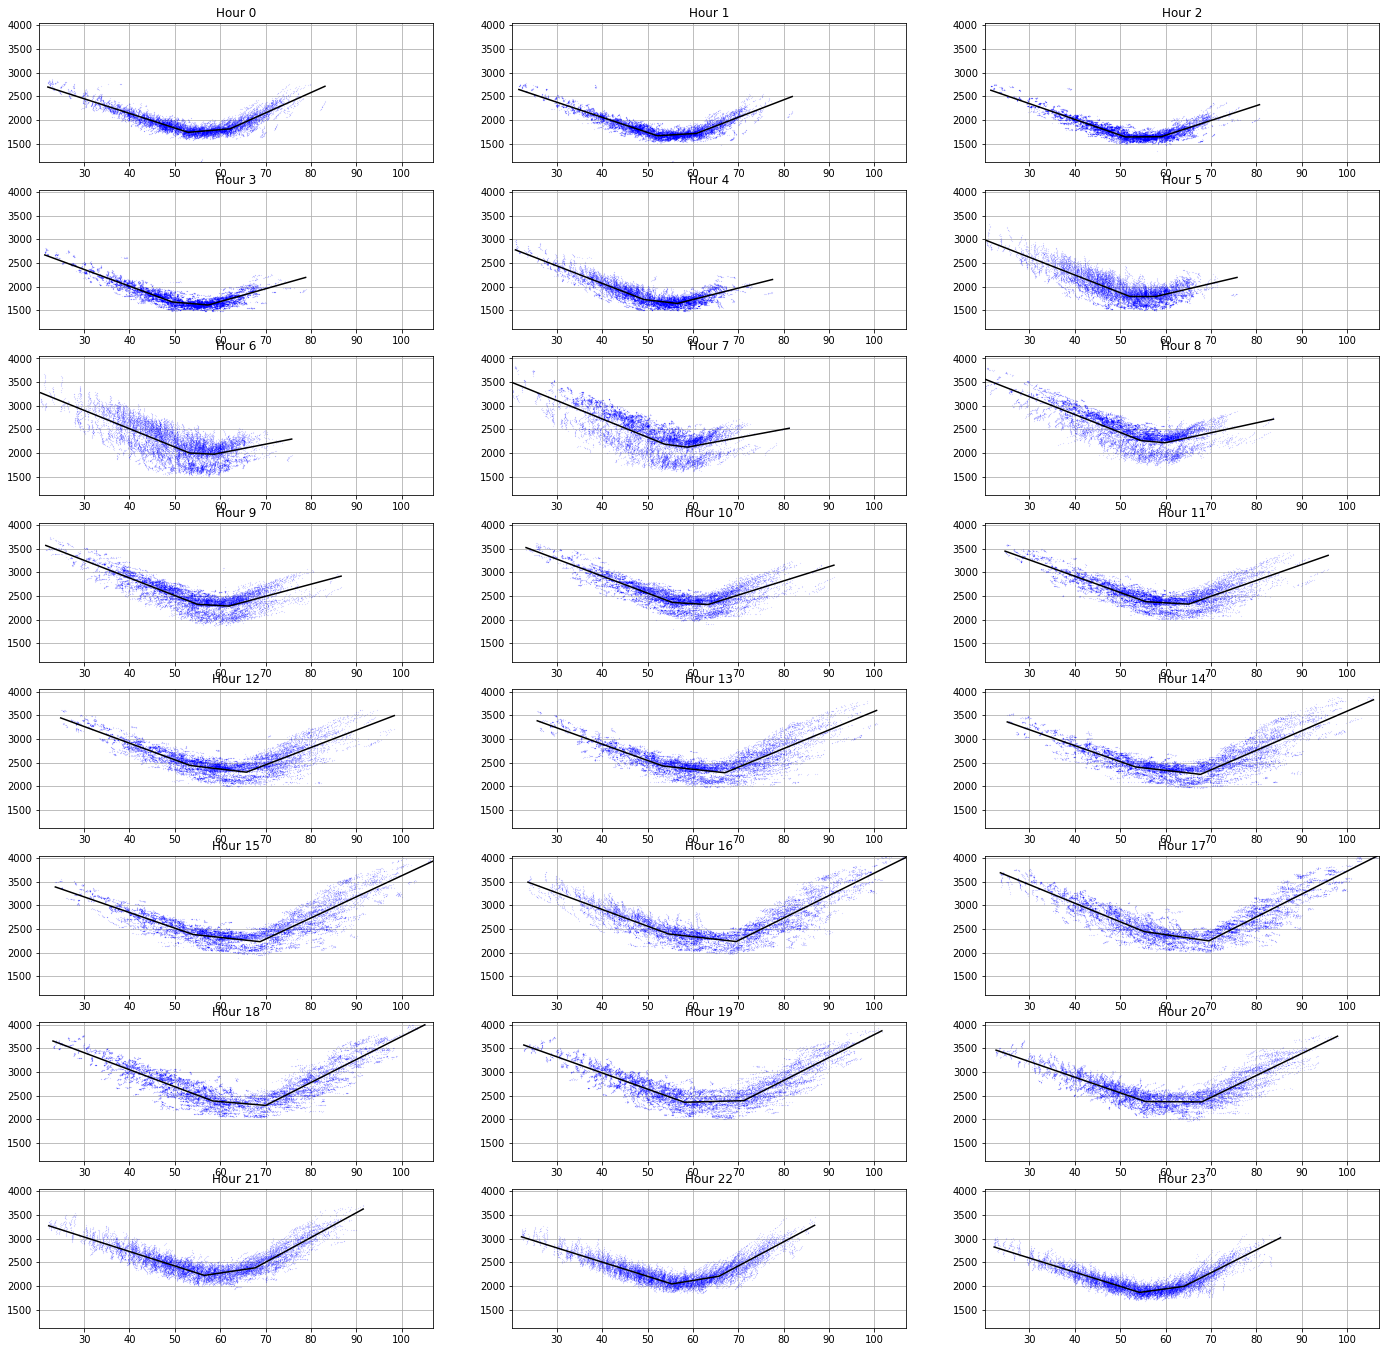

In [4]:
def get_model(data,config=config,saveplots=False):
    
    Pbase = []
    Pheat = []
    Pcool = []
    Tmin = []
    Theat = []
    Tcool = []
    Tmax = []
    Sbase = []
    Sheat = []
    Scool = []

    if saveplots:
        fig = plt.figure(figsize=(24,24))
        ax = fig.subplots(8,3).flatten()
        
    xmin = data["temperature"].min()
    xmax = data["temperature"].max()
    ymin = data["power"].min()
    ymax = data["power"].max()

    hour = list(map(lambda h: lm.get_hours(data,[h]),range(24)))
    model = []
    for h in range(24):

        T = hour[h]["temperature"]
        P = np.array(hour[h]["power"])
        
        model.append(Model(T,P,3))
        
        if model[h].s[0] >= model[h].s[1] and model[h].s[1] >= model[h].s[2]: # both slopes are too small

            model[h] = Model(T,P,1) # reduce model to simple linear regression

            Pbase.append((model[h].y[0]+model[h].y[1])/2)
            Pheat.append(np.nan)
            Pcool.append(np.nan)
            Tmin.append(model[h].x[0])
            Theat.append(np.nan)
            Tcool.append(np.nan)
            Tmax.append(model[h].x[1])
            Sbase.append(model[h].s[0])
            Sheat.append(np.nan)
            Scool.append(np.nan)

        elif model[h].s[0] >= model[h].s[1] : # only heating slope is too small
            
            model[h] = Model(T,P,2) # remove heating segment

            Pbase.append((model[h].y[0]+model[h].y[1])/2)
            Pheat.append(np.nan)
            Pcool.append(model[h].y[1])
            Tmin.append(model[h].x[0])
            Theat.append(np.nan)
            Tcool.append(model[h].x[1])
            Tmax.append(model[h].x[2])
            Sbase.append(model[h].s[0])
            Sheat.append(np.nan)
            Scool.append(model[h].s[1])

        elif model[h].s[1] >= model[h].s[2] : # only cooling slope is too small

            model[h] = Model(T,P,2) # remove cooling segment

            Pbase.append((model[h].y[1]+model[h].y[2])/2)
            Pheat.append(model[h].y[0])
            Pcool.append(np.nan)
            Tmin.append(model[h].x[0])
            Theat.append(model[h].x[1])
            Tcool.append(np.nan)
            Tmax.append(model[h].x[2])
            Sbase.append(model[h].s[1])
            Sheat.append(model[h].s[0])
            Scool.append(np.nan)

        else: # both slopes are ok
            
            Pbase.append((model[h].y[1]+model[h].y[2])/2)
            Pheat.append(model[h].y[0])
            Pcool.append(model[h].y[-1])
            Tmin.append(model[h].x[0])
            Theat.append(model[h].x[1])
            Tcool.append(model[h].x[2])
            Tmax.append(model[h].x[-1])
            Sbase.append(model[h].s[1])
            Sheat.append(model[h].s[0])
            Scool.append(model[h].s[2])

        if saveplots:
            ax[h].plot(T,P,'.',ms=0.1,color='blue')
            ax[h].plot(model[h].x,model[h].y,color='black')
            ax[h].set_xlim([xmin,xmax])
            ax[h].set_ylim([ymin,ymax])
            ax[h].set_title(f"Hour {h}")
            ax[h].grid()
        
    return pd.DataFrame({"Pbase": Pbase, "Pheat": Pheat, "Pcool": Pcool,
                         "Tmin":  Tmin,  "Theat": Theat, "Tcool": Tcool, "Tmax": Tmax,
                         "Sbase": Sbase, "Sheat": Sheat, "Scool": Scool})

model = get_model(data,saveplots=True)
model

This code generates an animation of the 24 hours of load data

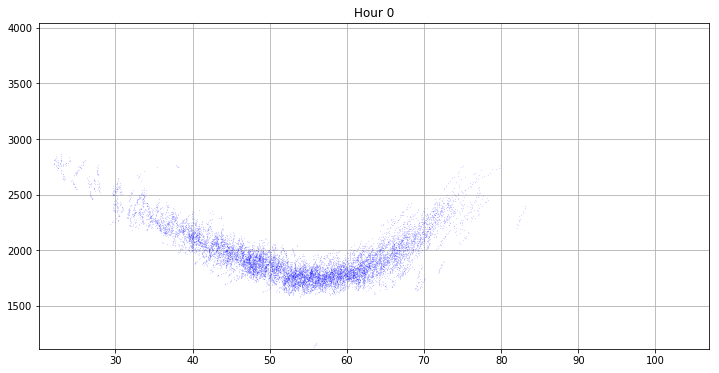

In [5]:
from matplotlib.animation import FuncAnimation
fig = plt.figure(figsize=(12,6))
ax = fig.subplots()

hour = list(map(lambda h: lm.get_hours(data,[h]),range(24)))
scatter, = ax.plot(hour[0]['temperature'],hour[0]['power'],'.',color='blue',ms=0.1)

ax.set_xlim([data["temperature"].min(),data["temperature"].max()])
ax.set_ylim([data["power"].min(),data["power"].max()])
ax.grid()

def update(h):
    scatter.set_xdata(hour[h]['temperature'])
    scatter.set_ydata(hour[h]['power'])
    ax.set_title(f'Hour {h}')
    return scatter, ax

anim = FuncAnimation(fig,update,frames=np.arange(0,24),interval=60)
anim.save('profiles.gif',dpi=80,writer='pillow')
plt.show()

This generates a plot of the heating and cooling balance temperatures found using this method.

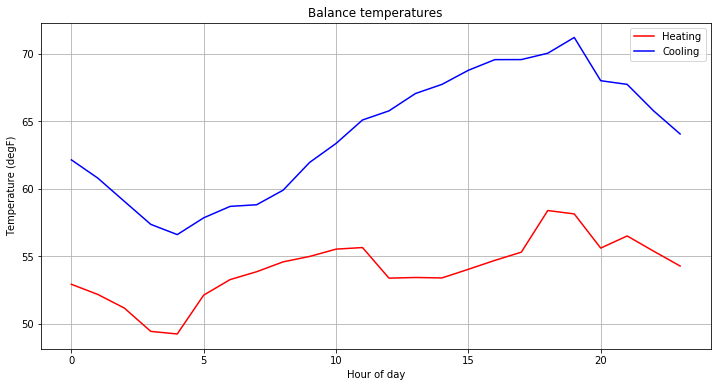

In [6]:
plt.figure(figsize=(12,6))
plt.plot(list(range(24)),model["Theat"],color='red',label='Heating')
plt.plot(list(range(24)),model["Tcool"],color='blue',label='Cooling')
plt.xlabel('Hour of day')
plt.ylabel('Temperature (degF)')
plt.grid()
plt.title('Balance temperatures')
plt.legend()
plt.savefig('balance.png')
plt.show()